In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import chardet
import warnings
import scipy.stats as stats
from scipy.constants import R
from scipy.optimize import differential_evolution, fmin, curve_fit
from scipy.interpolate import interp1d
from scipy import integrate
from tqdm.auto import tqdm
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings('ignore')

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = False

# Указываем название элемента, с  работатьработаткоторым хотим 
ELEMENT = 'Dy'

# Указываем путь к папке
folder_path = "src/TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Создаём массив из файлов, с названием элмента в начале
tga_file = [file for file in file_list if file.startswith(ELEMENT)]

# Определяем кодировку файла
with open(os.path.join(folder_path, tga_file[0]), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из первого CSV файла в массиве
df = pd.read_csv(
    os.path.join(folder_path, tga_file[0]),    
    encoding=file_encoding,    
)


# Вывод первых пяти строк данных
df.head()

,temperature;rate_3;rate_5;rate_10;rate_3_diff;rate_5_diff;rate_10_diff;rate_3_diff_reaction_0;rate_3_diff_reaction_1;rate_3_diff_reaction_2;rate_3_diff_reaction_3;rate_3_diff_reaction_4;rate_3_diff_reaction_5;rate_3_diff_reaction_6;rate_3_diff_cumulative;rate_5_diff_reaction_0;rate_5_diff_reaction_1;rate_5_diff_reaction_2;rate_5_diff_reaction_3;rate_5_diff_reaction_4;rate_5_diff_reaction_5;rate_5_diff_reaction_6;rate_5_diff_cumulative;rate_10_diff_reaction_0;rate_10_diff_reaction_1;rate_10_diff_reaction_2;rate_10_diff_reaction_3;rate_10_diff_reaction_4;rate_10_diff_reaction_5;rate_10_diff_reaction_6;rate_10_diff_cumulative
0,31.63192;99.99894;100.07588;99.96317;0.0001893...
1,32.58683;99.99902;100.04476;99.9709;0.00038844...
2,33.54175;100.00064;100.03758;99.9765;-0.000336...
3,34.49666;100.0006;100.03165;99.98113;-0.000609...
4,35.45158;99.99498;100.03084;99.97782;0.0002907...


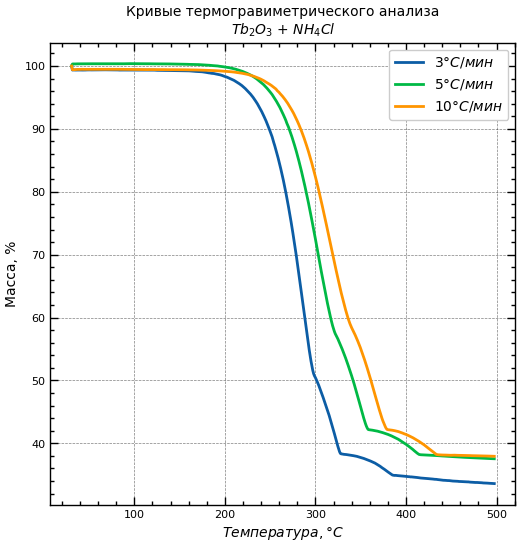

In [67]:
# Задаём константы для графиков
IS_PLOT = True
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8 
# рабочие константы
heating_rates = np.array(['3','5', '10']) # Скорости нагрева представленные в данных
CONSTRAINT = 0.005 # Отсечение значений ниже максимума от _ для рисунка DTG реакции
ALPHA_MIN = 0.00001 # Минимальная конверсия
ALPHA_MAX = 0.99999 # Максимальная конверсия
CONVERSION_BINS = 100 # Для безмодельных методов
# Рисунок какой реакции выводить на экран
TARGET_REACTION = 'reaction_0'
TARGET_RATE = 'rate_3'
# Функция аппроксимации рядом разложения p(x) для интегральных методов
def p(x):
    term = np.exp(-x)/x
    numerator = x**7 + 70*x**6 + 1886*x**5 + 24920*x**4 + 170136*x**3 + 577584*x**2 + 844560*x + 357120
    denominator = x**8 + 72*x**7 + 2024*x**6 + 28560*x**5 + 216720*x**4 + 880320*x**3 + 1794240*x**2 + 1572480*x + 403200    
    result = numerator / denominator    
    return term*result

# Проверяем, существует ли папка, и если нет, создаем ее
if not os.path.exists(f"imgs/{ELEMENT}"):
    os.makedirs(f"imgs/{ELEMENT}")

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

# Рисуем кривые
for rate in heating_rates:
    axes.plot(df['temperature'], df['rate_' + rate], label=f'${rate}°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('$Температура, °С$', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)

# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа\n' 
               + f'${ELEMENT}_2 O_3$ + $NH_4 Cl$', 
    fontsize=MEDIUM_SIZE)

# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Сохраняем рисунок
plt.savefig(f"imgs/{ELEMENT}/{ELEMENT}_DTA.png")

plt.show()

In [68]:
# Указываем путь к папке
folder_path = "src"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Создаём массив из файлов, с названием элмента в начале
tga_file = [file for file in file_list if file.startswith(ELEMENT)]

# Определяем кодировку файла
with open(os.path.join(folder_path, tga_file[0]), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из первого CSV файла в массиве с разделителем ; и десятичной запятой
_df = pd.read_csv(
    os.path.join(folder_path, tga_file[0]),    
    encoding=file_encoding,
    sep=";",
    decimal=",",
    names=["t", "m"],  # Присваивание имен столбцам
    header=None  # Это уберет заголовок из CSV, так как мы предоставляем наши собственные имена
)

# Замена запятой на точку в числовых значениях
_df = _df.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

# Вывод первых пяти строк данных
_df.head()

Exception: No files found in the specified directory.

In [ ]:
# Интерполируем данные
interpolated_values = np.interp(df['temperature'], _df['t'], _df['m'])

# Добавляем интерполированные значения в датафрейм df
df['rate_3'] = interpolated_values



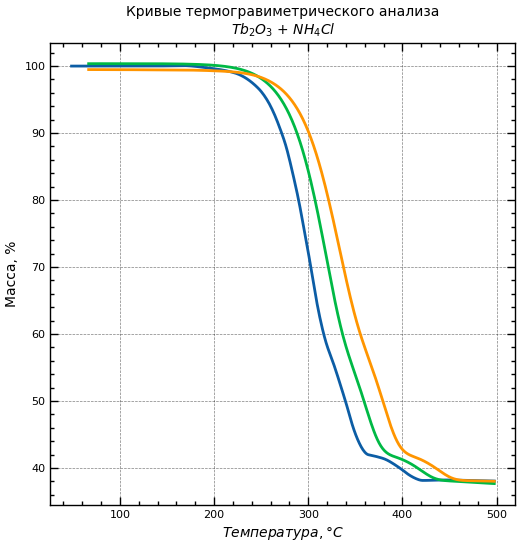

In [ ]:
# Применяем скользящее среднее к каждому столбцу данных
for rate in heating_rates:
    df['rate_' + rate] = df['rate_' + rate].rolling(window=20).mean()

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))
# Рисуем кривые
for rate in heating_rates:
    axes.plot(df['temperature'], df['rate_' + rate], label=f'${rate}°C/мин$')
    

# Добавляем подписи на оси
axes.set_xlabel('$Температура, °С$', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)

# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа\n' 
               + f'${ELEMENT}_2 O_3$ + $NH_4 Cl$', 
    fontsize=MEDIUM_SIZE)

# Настраиваем размер легенды и подписей осей
#axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)


In [ ]:
df.to_csv('Tb.csv')

In [ ]:
areas = {}
for rate in heating_rates:
    y_values = df['rate_' + rate].dropna()  # Удаляем NaN значения
    x_values = df['temperature'][df['rate_' + rate].notna()]  # Берем соответствующие значения температуры
    area = np.trapz(y_values, x_values)
    areas[rate] = area
    print(f"Площадь под функцией {rate}°C/мин: {area:.2f}")


Площадь под функцией 5°C/мин: 31171.08
Площадь под функцией 10°C/мин: 32024.45


In [ ]:

# Интерполируем данные
df['interpolated_5'] = np.interp(df['temperature'], df['temperature'], df['rate_5'].diff())
df['interpolated_10'] = np.interp(df['temperature'], df['temperature'], df['rate_10'].diff())

# Находим разницу между данными 10 и 5
df['difference_10_5'] = df['interpolated_10'] - df['interpolated_5']

# Применяем половину разницы к данным 5
df['rate_3_d'] = df['interpolated_5'] - 0.5 * df['difference_10_5']
df['rate_3'] = df['rate_3_d'].cumsum()


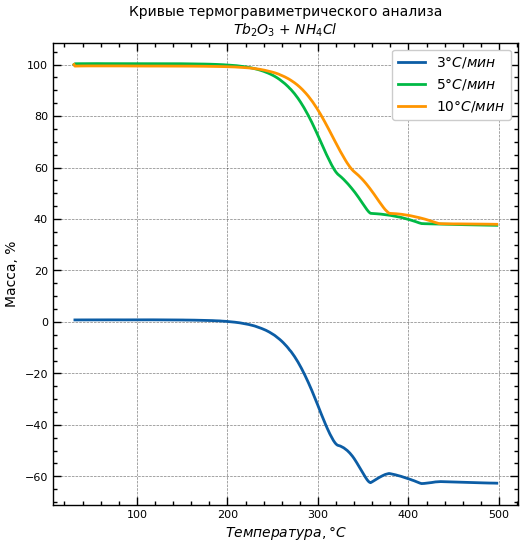

In [ ]:
# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

# Рисуем кривые
for rate in heating_rates:
    axes.plot(df['temperature'], df['rate_' + rate], label=f'${rate}°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('$Температура, °С$', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)

# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа\n' 
               + f'${ELEMENT}_2 O_3$ + $NH_4 Cl$', 
    fontsize=MEDIUM_SIZE)

# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
